# Image (Clothes) Recognition

### Import Libraries for loading dataset, optimize gradient descent, saving model and plotting curves

In [2]:
import numpy as np
from scipy.optimize import fmin_cg
import pickle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Loading 60 000 images of clothes (28x28 pixels)

In [3]:
data = keras.datasets.fashion_mnist

### Splitting the dataset on train and test sets

In [30]:
(train_images, train_labels), (test_images, test_labels) = data.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Unrolling the images into 784 features for each

In [31]:
m = np.shape(train_images)[0] # number of  examples

train_images = train_images.reshape(m, 784) # flatten 28x28 matrix of pixels to 784x1  vector of features
test_images = test_images.reshape(np.shape(test_images)[0], 784)

# Some useful variables
n = np.shape(train_images)[1] # number of features
k = 10 # number of labels

### Scaling features

In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

### Plotting the examples

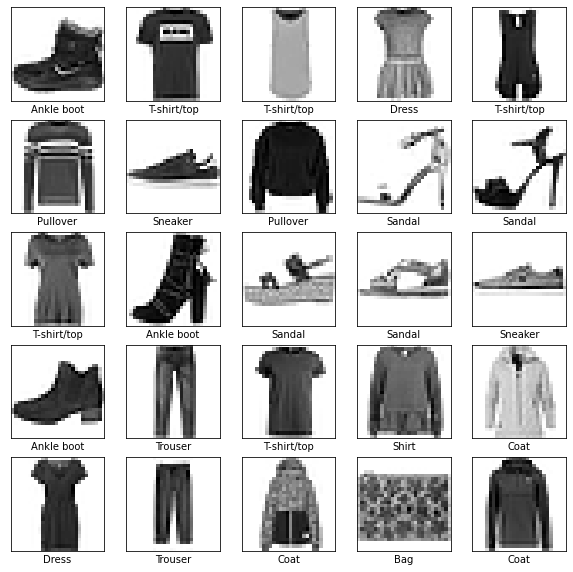

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [7]:
def sigmoid(z):
    #return 1.0 / (1.0 + np.exp(-z))
    return np.divide(1.0, (np.add(1.0, np.exp(np.negative(z)))))

In [8]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z), np.subtract(1, sigmoid(z)))

In [9]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = np.sqrt(6)/(np.sqrt(L_in + L_out))
    return np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

In [18]:
def costFunction(nn_params, X, y, lmda):
    
    X = np.reshape(X, (-1, 784))
    
    Theta1 = np.reshape(nn_params[0:19625], (-1, 785)) 
    Theta2 = np.reshape(nn_params[19625:19885], (-1, 26))
    
    m = np.shape(X)[0]
    Y = np.zeros([m, k])
    for i in range(m):
        j = y[i]
        Y[i, j-1] = 1

    a1 = np.concatenate([np.ones([m, 1]), X], axis=1)

    z2 = np.matmul(a1, np.transpose(Theta1))

    a2 = np.concatenate([np.ones([m, 1]), sigmoid(z2)], axis=1)

    z3 = np.matmul(a2, np.transpose(Theta2))

    a3 = sigmoid(z3)
    
    logErrors = np.multiply(Y, np.log(a3)) + np.multiply(np.subtract(1, Y), np.log(np.subtract(1, a3)))

    reg = lmda/(2*m) * (np.sum((Theta1[:, 1:]**2)) + np.sum((Theta2[:, 1:]**2)))

    return -1/m * np.sum(logErrors) + reg

In [19]:
def backPropagate(nn_params, X, y, lmda):
    
    X = np.reshape(X, (-1, 784))
    
    Theta1 = np.reshape(nn_params[0:19625], (-1, 785)) 
    Theta2 = np.reshape(nn_params[19625:19885], (-1, 26))
    
    m = np.shape(X)[0]
    Y = np.zeros([m, k])
    for i in range(m):
        j = y[i]
        Y[i, j-1] = 1
        
    a1 = np.concatenate([np.ones([m, 1]), X], axis=1)

    z2 = np.matmul(a1, np.transpose(Theta1))

    a2 = np.concatenate([np.ones([m, 1]), sigmoid(z2)], axis=1)

    z3 = np.matmul(a2, np.transpose(Theta2))

    a3 = sigmoid(z3)

    d3 = np.subtract(a3, Y)

    d2 = np.multiply(np.matmul(d3, Theta2[:, 1:]), sigmoidGradient(z2))

    Delta1 = np.matmul(np.transpose(d2), a1)
    Delta2 = np.matmul(np.transpose(d3), a2)

    Theta1_grad = np.divide(Delta1, m)
    Theta2_grad = np.divide(Delta2, m)

    Theta1_grad[:, 2:] = Theta1_grad[:, 2:] + lmda/m*Theta1_grad[:, 2:]
    Theta2_grad[:, 2:] = Theta2_grad[:, 2:] + lmda/m*Theta2_grad[:, 2:]

    return np.concatenate([Theta1_grad.flatten(), Theta2_grad.flatten()])

In [20]:
def fmin_cg_train(X_param, y_param, lmda):
    randomThetas_unrolled = np.concatenate([randInitializeWeights(784, 25).flatten(), randInitializeWeights(25, 10).flatten()])
    return fmin_cg(costFunction, fprime=backPropagate, x0=randomThetas_unrolled, args=(X_param.flatten(), y_param.flatten(), lmda), maxiter=400, disp=True, full_output=True )

In [42]:
def nn_predict(learned_Thetas, X):
    Theta1 = np.reshape(learned_Thetas[0:19625], (-1, 785)) 
    Theta2 = np.reshape(learned_Thetas[19625:19885], (-1, 26))

    m = np.shape(X)[0]
    
    a1 = np.concatenate([np.ones([m, 1]), X], axis=1)
    z2 = np.matmul(a1, np.transpose(Theta1))
    a2 = np.concatenate([np.ones([m, 1]), sigmoid(z2)], axis=1)
    z3 = np.matmul(a2, np.transpose(Theta2))
    a3 = sigmoid(z3)

    return np.add(np.argmax(a3, axis=1), 1)

In [45]:
def accuracy(learned_Thetas, X_test, y_test):
    predictions = nn_predict(learned_Thetas, X_test)
    return np.mean((predictions == y_test.flatten()) * 100)

In [49]:
my_cls_3 = fmin_cg_train(train_images, train_labels, 1)

<ipython-input-7-5047fd5f1516>:3: RuntimeWarning: overflow encountered in exp
  return np.divide(1.0, (np.add(1.0, np.exp(np.negative(z)))))


         Current function value: 1.145309
         Iterations: 400
         Function evaluations: 655
         Gradient evaluations: 655


In [64]:
accuracy(my_cls_2[0], test_images, test_labels)

<ipython-input-7-5047fd5f1516>:3: RuntimeWarning: overflow encountered in exp
  return np.divide(1.0, (np.add(1.0, np.exp(np.negative(z)))))


71.47

## Saving the model with lambda = 0.1

In [54]:
with open('./nn_clothes.pkl', 'wb') as f:
    pickle.dump(my_cls_2, f)